# **스파크 colab에 환경 구현**

In [1]:
# jdk 툴 설치
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# apache spark download - 하둡 버전에 따라 spakr 와 하둡 변경 (밑에 tgz 파일 설치 및 pip install)
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
# 명령어로 spark - hadoop 파일 압축 풀기
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
# spark 설치
!pip install -q findspark

In [2]:
import os
# spark 환경변수 설정 - java(jdk) ,spark(spark) 2개다 설정해줘야함
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
#import spark 말고 findspark로 spark파일을 못찾는경우에 빠르게 설치 가능
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

# **트랜스포메이션(Transformations)과 액션(Actions)**

**트랜스포메이션(Transformations)**

결과값으로 새로운 RDD를 반환한다.

지연 실행(Lazy Execution)이 된다는 특징이 있다.

트랜스포메이션은 네로우(Narrow)와 와이드(Wide)로 나눌 수 있다.

**네로우(Narrow) 트랜스포메이션**

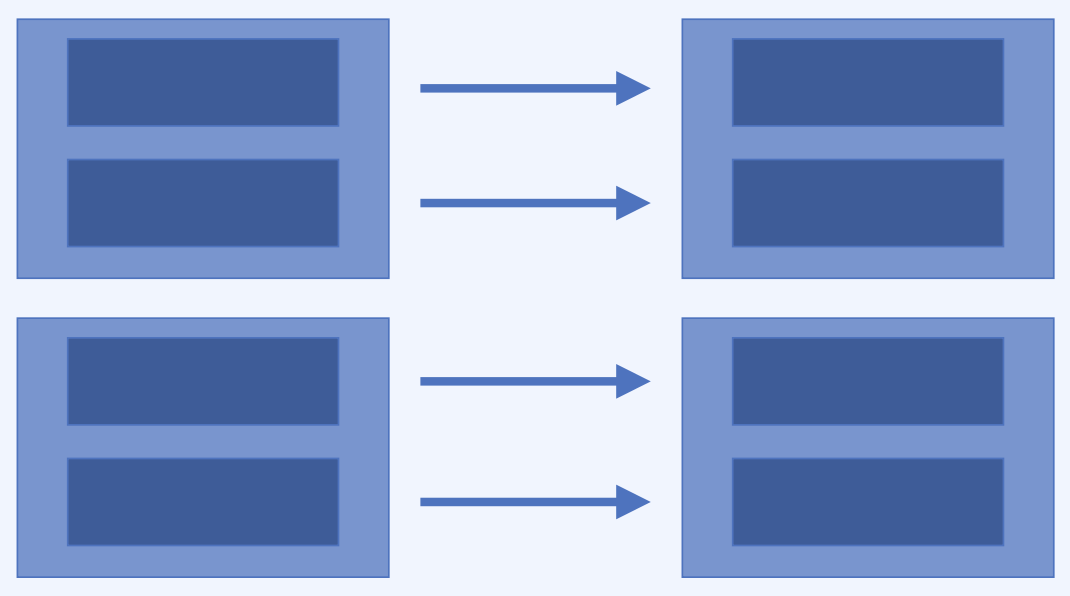

1대 1로 변환된다는 특정이 있다.

대표적으로 filter(), map(), flatMap(), sample(), union() 등이 있다.

1열을 조작하기 위해 다른 열과 파티션의 데이터를 끌어다 쓸 필요가 없다.

정렬 같은 경우 새로운 RDD를 만들 때 다른 열을 참고해야 하는데 이는 많은 통신이 일어나며, 그렇기에 네로우 트랜스포메이션은 빠르다고 볼 수 있다.

**와이드(Wide) 트랜스포메이션**

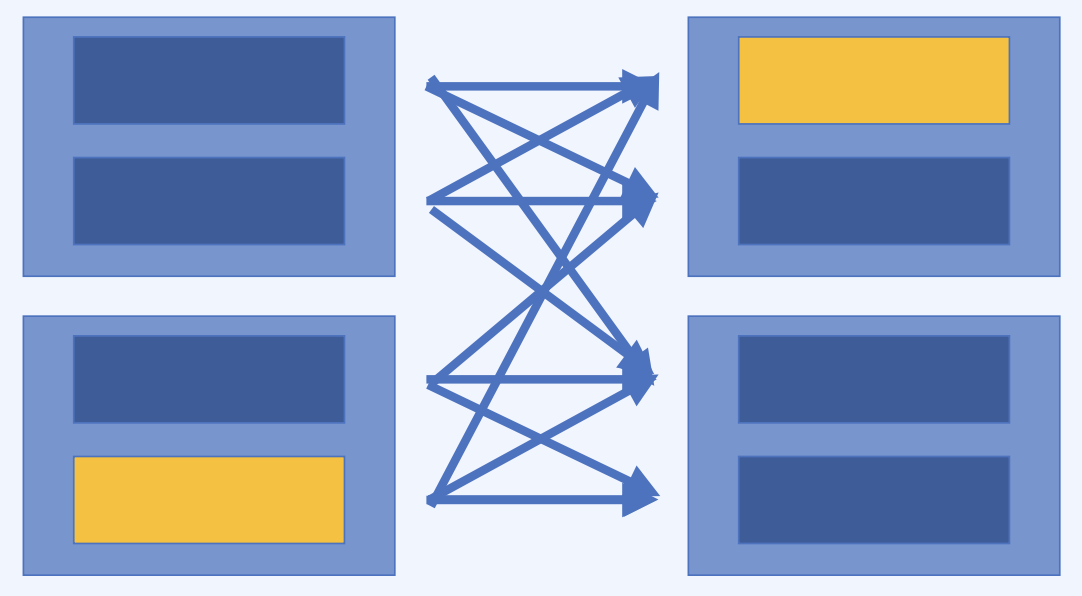

셔플링을 한다는 특징이 있다.

대표적인 예로 intersection and join, distinct, cartesial, reduceByKey(), groupByKey() 등의 함수가 있다.

아웃풋 RDD의 파티션에 다른 파티션의 데이터가 들어갈 수 있다.

데이터가 나뉘어진 파티션을 왔다 갔다하면, 통신이 많이 필요하기 때문에 성능 상 많은 리소스를 요구한다. 이를 최소화하거나 최적화하여야 성능을 끌어내기 좋다.

함수

map()

flatMap()

filter()

distinct()

reduceByKey()

groupByKey()

mapValues()

flatMapValues()

sortByKey()

코드

프로그램이 트랜스포메이션을 만날 때 새로운 알디디를 만들지 않고 액션을 만나야 연산을 시작하면서 만들어진다.

트랜스포메이션을 만나게 되면 신텍스를 체크 한 다음에 기억을 하고 넘어간다.

트랜스포메이션을 여러번 거치면 순서대로 변환 과정을 기억해놓으며 하나의 DAGs를 만들게 된다.

In [4]:
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local").setAppName("transformations_actions")
sc = SparkContext(conf = conf)

In [5]:
sc.parallelize([1, 2, 3]).map(lambda x: x + 2).collect() # 새로운 RDD 생성

[3, 4, 5]

In [6]:
movies = [
    "그린 북",
    "매트릭스",
    "토이 스토리",
    "캐스트 어웨이",
    "포드 V 페라리",
    "보헤미안 랩소디",
    "빽 투 더 퓨처",
    "반지의 제왕",
    "죽은 시인의 사회"
]
movies_rdd = sc.parallelize(movies)
movies_rdd.collect()


['그린 북',
 '매트릭스',
 '토이 스토리',
 '캐스트 어웨이',
 '포드 V 페라리',
 '보헤미안 랩소디',
 '빽 투 더 퓨처',
 '반지의 제왕',
 '죽은 시인의 사회']

In [7]:
flat_movies = movies_rdd.flatMap(lambda x: x.split(" ")) # 어떻게 나눌 지 지정
flat_movies.collect()

['그린',
 '북',
 '매트릭스',
 '토이',
 '스토리',
 '캐스트',
 '어웨이',
 '포드',
 'V',
 '페라리',
 '보헤미안',
 '랩소디',
 '빽',
 '투',
 '더',
 '퓨처',
 '반지의',
 '제왕',
 '죽은',
 '시인의',
 '사회']

In [8]:
filtered_movies = flat_movies.filter(lambda x: x != "매트릭스") # 필터링
filtered_movies.collect()

['그린',
 '북',
 '토이',
 '스토리',
 '캐스트',
 '어웨이',
 '포드',
 'V',
 '페라리',
 '보헤미안',
 '랩소디',
 '빽',
 '투',
 '더',
 '퓨처',
 '반지의',
 '제왕',
 '죽은',
 '시인의',
 '사회']

In [9]:
num1 = sc.parallelize([1, 2, 3, 4])
num2 = sc.parallelize([4, 5, 6, 7, 8, 9, 10])
num1.intersection(num2).collect()

[4]

In [10]:
num1.union(num2).collect() # 모든 값이 합쳐진다.

[1, 2, 3, 4, 4, 5, 6, 7, 8, 9, 10]

In [11]:
num1.subtract(num2).collect() # 중복된 데이터가 사라진다.

[2, 1, 3]

In [12]:
num_union = num1.union(num2)
num_union.sample(True, .5, seed=6).collect() # True: 리샘플링 여부 / .5: 샘플링 할 비율

[2, 10]

In [13]:
foods = sc.parallelize(["짜장면", "마라탕", "짬뽕", "떡볶이", "쌀국수", "짬뽕", "짜장면", "짜장면", "짜장면",  "라면", "우동", "라면", "치킨", "돈까스", "회", "햄버거", "피자"])
foods_group = foods.groupBy(lambda x: x[0]) # 그룹핑
res = foods_group.collect()
for (k, v) in res:
    print(k, list(v))

짜 ['짜장면', '짜장면', '짜장면', '짜장면']
마 ['마라탕']
짬 ['짬뽕', '짬뽕']
떡 ['떡볶이']
쌀 ['쌀국수']
라 ['라면', '라면']
우 ['우동']
치 ['치킨']
돈 ['돈까스']
회 ['회']
햄 ['햄버거']
피 ['피자']


In [14]:
nums = sc.parallelize([1,2,3,4,5,6,7,8,9,10])
list(nums.groupBy(lambda x: x % 2).collect()[1][1])

[2, 4, 6, 8, 10]

**액션(Actions)**

결과값을 연산하여 리스트나 파이썬 오브젝트를 출력하거나 저장한다.

즉시 실행(Eager Execution)이 된다는 특징이 있다.

함수

collect()

count()

countByValue()

take()

top()

reduce()

fold()

foreach()

# **코드**

In [15]:
sc.stop() # 위에서 생성한 스파크 컨텍스트 중단

conf = SparkConf().setMaster("local").setAppName("transformations_actions")
sc = SparkContext(conf = conf)
sc.getConf().getAll() # 설정 리스트 확인


[('spark.master', 'local'),
 ('spark.app.startTime', '1666591524616'),
 ('spark.app.id', 'local-1666591524862'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'transformations_actions'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'e36849744ea2'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '34363')]

In [16]:
foods = sc.parallelize(["짜장면", "마라탕", "짬뽕", "떡볶이", "쌀국수", "짬뽕", "짜장면", "짜장면", "짜장면",  "라면", "우동", "라면"]) # 텍스트파일 함수와 같이 RDD를 생성
foods

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:274

In [17]:
foods.collect()

# RDD 데이터 확인
# 벨류를 모두 가져올 수 있는데 디버깅이나 개발 환경에서만 사용해야하고 실제 프로덕트 상황에서 지양해야한다.
# 데이터를 모두 가져오기 때문에 너무 낭비가 되기 때문에 스파크를 쓰는 의미가 없어진다.

['짜장면', '마라탕', '짬뽕', '떡볶이', '쌀국수', '짬뽕', '짜장면', '짜장면', '짜장면', '라면', '우동', '라면']

In [18]:
foods.countByValue() # 벨류 값 계산하여 키 벨류 형태로 전시

defaultdict(int,
            {'짜장면': 4,
             '마라탕': 1,
             '짬뽕': 2,
             '떡볶이': 1,
             '쌀국수': 1,
             '라면': 2,
             '우동': 1})

In [19]:
foods.take(3), foods.first() # 3개의 엘리먼트, 첫 값 전시

(['짜장면', '마라탕', '짬뽕'], '짜장면')

In [20]:
foods.count(), foods.distinct().count() #엘리먼트 갯수 전시,  엘리먼트 갯수 유니크하여 전시

(12, 7)

In [21]:
# foreach: 요소를 하나하나 꺼내어 하나의 함수를 작용시키는데 쓰인다.
foods.foreach(lambda x: print(x))
# 실행시켜도 리턴값은 없지만, 워커 노드에서 실행이 되기 때문에 현재 드라이버 프로그램에서는 보이지 않는다.
# RDD를 연산하거나 로그를 세이브할 때 유용하게 쓰인다.

# **ey-Value RDD의 트랜스포메이션과 액션**
대표적인 트랜스포메이션

groupByKey

reduceByKey


mapValues

keys

join(leftOuterJoin, rightOuterJoin) 등이 있다.

액션에는 countByKey가 있다.

대부분의 오퍼레이션이 트랜스포메이션인 경우가 많은데, 키 벨류 RDD 처리 과정의 
결과값이 파티션이 유지가 안되더라도 값이 굉장히 큰 경우가 많기 때문이다.

**groupByKey**

주어지는 키를 기준으로 그룹핑한다.

RDD.groupByKey(numPartitions=None, partitionFunc=<function portable_hash>)

In [22]:
rdd = sc.parallelize([('a', 1), ('b', 1), ('a', 1)])
sorted(rdd.groupByKey().mapValues(len).collect())

[('a', 2), ('b', 1)]

In [23]:
sorted(rdd.groupByKey().mapValues(list).collect())

[('a', [1, 1]), ('b', [1])]

len을 넣는다면 갯수, list를 넣는다면 리스트를 반환해준다.

**groupBykey 예제**

In [26]:
x = sc.parallelize([
    ('MATH', 7), ('MATH', 2), ('ENGLISH', 7), 
    ('SCIENCE', 7), ('ENGLISH', 4), ('ENGLISH', 9), 
    ('MATH', 8), ('MATH', 3), ('ENGLISH', 4), 
    ('SCIENCE', 6), ('SCIENCE', 9), ('SCIENCE', 5), 
], 3)

y = x.groupByKey()
print(y.getNumPartitions())

3


In [27]:
y = x.groupByKey(2) # 임의로 파티션 지정
print(y.getNumPartitions())

2


In [28]:
for t in y.collect():
    print(t[0], list(t[1]))

MATH [7, 2, 8, 3]
ENGLISH [7, 4, 9, 4]
SCIENCE [7, 6, 9, 5]


**reduceByKey**

Key를 기준으로 그룹을 만들고 합친다.

RDD.reduceByKey(func, numPartitions=None, partitionFunc=)

In [32]:
x = sc.parallelize([
    ('MATH', 7), ('MATH', 2), ('ENGLISH', 7), 
    ('SCIENCE', 7), ('ENGLISH', 4), ('ENGLISH', 9), 
    ('MATH', 8), ('MATH', 3), ('ENGLISH', 4), 
    ('SCIENCE', 6), ('SCIENCE', 9), ('SCIENCE', 5), 
], 3)

x.reduceByKey(lambda a, b: a+b).collect()

[('MATH', 20), ('ENGLISH', 24), ('SCIENCE', 27)]

**mapValues**
사용자가 정의한 함수를 값에 적용할 때 사용된다.

파티션과 키가 그대로 있다는 장점이 있다.

파티션과 키가 왔다 갔다 할 때 네트워크 코스트가 크기 때문에 성능을 향상시킬 수 있다.

In [33]:
x = sc.parallelize([("a", ["apple", "banana", "lemon"]), ("b", ["grapes"])])
def f(x): return len(x)
x.mapValues(f).collect()

[('a', 3), ('b', 1)]

**countByKey**
각 키가 가진 요소들을 센다.

In [34]:
rdd = sc.parallelize([("a", 1), ("b", 1), ("a", 1)])
sorted(rdd.countByKey().items())

[('a', 2), ('b', 1)]

**keys**
하나의 트랜스포메이션이며 모든 키를 가진 RDD를 생성한다.

In [35]:
m = sc.parallelize([(1, 2), (3, 4)]).keys()
m.collect()

[1, 3]

In [36]:
x = sc.parallelize([
    ('MATH', 7), ('MATH', 2), ('ENGLISH', 7), 
    ('SCIENCE', 7), ('ENGLISH', 4), ('ENGLISH', 9), 
    ('MATH', 8), ('MATH', 3), ('ENGLISH', 4), 
    ('SCIENCE', 6), ('SCIENCE', 9), ('SCIENCE', 5), 
], 3)

x.keys().distinct().count() # 키를 유니크하게 만들고 갯수를 반환

3

**Joins**

트랜스포메이션으로 작동하며 여러개의 RDD를 합치는데 사용된다.

대표적으로 두가지의 Join 방식이 존재한다.

Inner Join(join)

Outer Join(left outer, right outer)

**Inner Join**

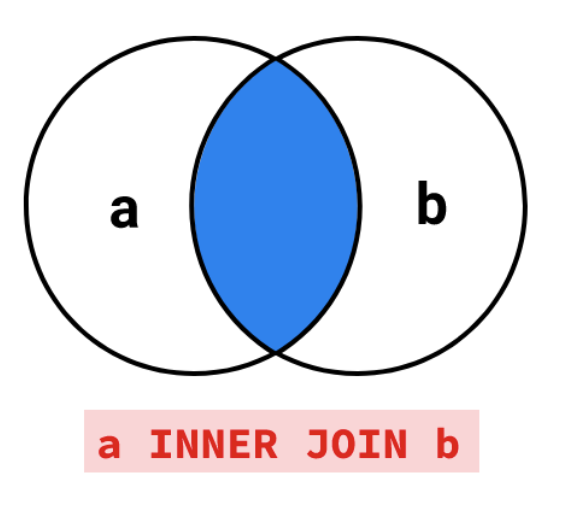

서로 연관된 데이터만 가져온다.

**Outer Join**

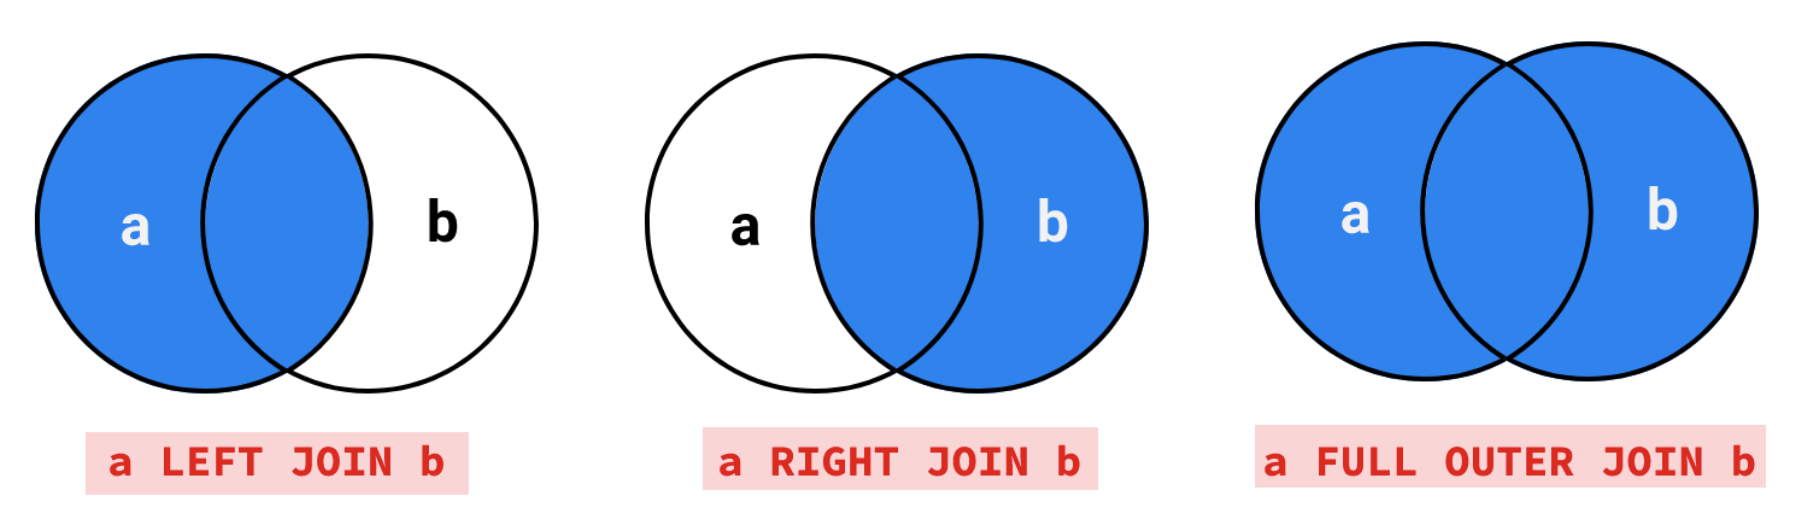

한쪽에는 데이터가 있고 다른쪽에 없는 경우, 데이터가 있는 쪽의 데이터를 출력한다.

leftOuterJoin: 왼쪽에 있는 데이터를 모두 출력, 반대편에 데이터가 없는 경우 None

rightOuterJoin: 오른쪽에 있는 데이터를 모두 출력, 반대편에 데이터가 없는 경우 None

In [37]:
rdd1 = sc.parallelize([('foo', 1), ('bar', 2), ('baz', 3)])
rdd2 = sc.parallelize([('foo', 4), ('bar', 5), ('baz', 6), ('zoo', 1)])

rdd1.join(rdd2).collect()

[('foo', (1, 4)), ('bar', (2, 5)), ('baz', (3, 6))]

In [38]:
rdd1.leftOuterJoin(rdd2).collect()

[('foo', (1, 4)), ('bar', (2, 5)), ('baz', (3, 6))]

In [39]:
rdd1.rightOuterJoin(rdd2).collect()

[('foo', (1, 4)), ('bar', (2, 5)), ('baz', (3, 6)), ('zoo', (None, 1))]